## univariable differential equation
$$
\frac{df}{dx} = f(x)
$$
see if we can find a solution for f(x) (see if it performs like the exponential function)

1) first step derive the tensor components for the f(x)

$$
z_i^{(l)} = \sum_j w_{ij}^{(l)} a_j^{(l-1)} + b_i^{(l)}
$$

$$
a_i^{(l)} = \phi(z_i^{(l)})
$$

$$
f(x) = \sum_j w_{ij}^{(L+1)} a_j^{(L)} + b_i^{(L+1)}
$$

2) second we derive the tensor components for the f'(x)

$$
\frac{df}{dx} = \sum_j w_{ij}^{(L+1)} \frac{da_j^{(L)}}{dx}
$$
where, (phi is derivtaive of z)
$$
\frac{da_j^{(l)}}{dx} = \phi'(z_i^{(l)}) \cdot \frac{dz_i^{(l)}}{dx}
$$
and
$$
\frac{dz_i^{(l)}}{dx} = \sum_j w_{ij}^{(l)} \frac{da_j^{(l-1)}}{dx}
$$
where (derivative of input with itself is always 1)
 
$$ 
\frac{da_j^{(0)}}{dx} = 1
$$

3) finally we derive the loss function we must fit in order to solve this equation (we will compare out results to the exponential)

$$
L = ||\frac{df}{dx} - f(x)||_2 = [\sum_j w_{ij}^{(L+1)} (a_j^{(L)} - \frac{da_j^{(L)}}{dx}) + b_i^{(L+1)}]^2
$$

where
$$
a_j^{(L)} - \frac{da_j^{(L)}}{dx} = \phi(z_i^{(l)}) -  \phi'(z_i^{(l)}) \cdot \frac{dz_i^{(l)}}{dx}
$$

4) define the components
- to start with we will use a 1d neural network, with a tanh activation function


## over a phase space of C, with no autograd just tensor maths
where
$$
f(x) = Ce^x
$$

**Description**
This code implements a physics-informed neural network (PINN) to solve the first-order ordinary differential equation (ODE) df/dx = f(x) with the initial condition f(0) = C. The solution is approximated as f(x) = C * exp(x). Below is a detailed breakdown of each component:


Epoch    0 | Loss: 2.25e+00 | Val Loss: 3.48e+01
Epoch  500 | Loss: 1.60e-01 | Val Loss: 8.31e+00
Epoch 1000 | Loss: 3.95e-02 | Val Loss: 1.73e+00
Epoch 1500 | Loss: 2.74e-02 | Val Loss: 7.89e-01
Epoch 2000 | Loss: 1.31e-02 | Val Loss: 4.92e-01
Epoch 2500 | Loss: 7.76e-03 | Val Loss: 2.34e-01
Epoch 3000 | Loss: 4.76e-02 | Val Loss: 2.37e-01
Epoch 3500 | Loss: 3.03e-03 | Val Loss: 1.23e-01
Epoch 4000 | Loss: 3.11e-03 | Val Loss: 1.61e-01
Epoch 4500 | Loss: 3.35e-03 | Val Loss: 1.50e-01
Epoch 5000 | Loss: 1.31e-03 | Val Loss: 5.96e-02


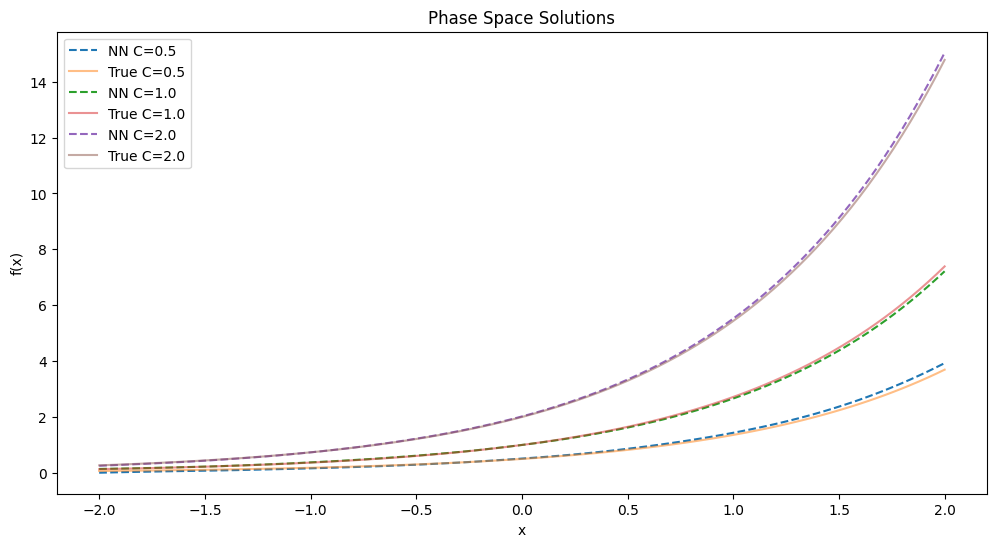

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


class PhaseSpaceODE(nn.Module):
    """
    Neural network model for solving ODEs in phase space.
    
    Solves the ODE df/dx = f(x) with initial condition f(0) = C by learning 
    the solution family f(x; C) = C * exp(x) across different initial conditions.
    """
    
    def __init__(self, hidden_size: int = 64, num_layers: int = 3):
        """
        Initialize the neural network architecture.
        
        Params:
        ------------
        - hidden_size (int): Number of neurons in each hidden layer
        - num_layers (int): Total number of hidden layers (minimum 1)
        """
        super(PhaseSpaceODE, self).__init__()
        self.layers = nn.ModuleList()
        
        # Input dimension: 2 (x + initial condition C)
        self.layers.append(nn.Linear(2, hidden_size))
        
        # Add remaining hidden layers
        for _ in range(num_layers-1):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
            
        # Final output layer (single output: f(x))
        self.output = nn.Linear(hidden_size, 1)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network.
        
        Params:
        ----------
        - x (torch.Tensor): Input tensor of shape [batch_size, 2] containing [x, C] pairs
            
        Returns:
        ----------
        - Predicted f(x) values of shape [batch_size, 1]
        """
        # Pass through hidden layers with tanh activation
        for layer in self.layers:
            x = torch.tanh(layer(x))
        return self.output(x)
    
    def compute_derivative(self, inputs: torch.Tensor) -> torch.Tensor:
        """
        Compute df/dx using forward-mode automatic differentiation.
        
        Implements custom derivative calculation through network layers without 
        relying on PyTorch autograd. This computes the analytical derivative of 
        the network output with respect to the input x.
        
        Params:
        ---------
        - inputs (torch.Tensor): Input tensor of shape [batch_size, 2] containing [x, C] pairs
            
        Returns:
        -----------
        - df/dx (torch.Tensor) values of shape [batch_size, 1]
        """
        # Split input into x and C components (retaining 2D shape)
        x = inputs[:, 0:1]  # dx/dx = 1, dC/dx = 0 (partial derivatives)
        C = inputs[:, 1:2]
        
        # Initialize derivative tracking: da_prev = da/dx (partial derivatives)
        da_prev = torch.zeros_like(inputs)
        da_prev[:, 0] = 1.0  # dx/dx = 1, dC/dx = 0 (partial derivatives)
        
        a = inputs  # Current activation
        
        for layer in self.layers:
            # Linear transformation
            z = layer(a)
            # Non-linear activation
            a = torch.tanh(z)
            
            # Compute Jacobian-vector product: dz/dx = da_prev * W^T
            W = layer.weight  # [out_size, in_size]
            dz_dx = torch.mm(da_prev, W.t()) 
            
            # Chain rule: da/dx = (1 - tanh^2(z)) * dz/dx
            da_prev = (1 - a**2) * dz_dx
            
        # Final derivative calculation through output layer
        W_out = self.output.weight
        dfdx = torch.mm(da_prev, W_out.t())
        return dfdx


def train_model(model: nn.Module, epochs: int = 3000, lr: float = 0.001) -> nn.Module:
    """
    Train the PhaseSpaceODE model using physics-informed loss functions.
    
    The training incorporates two loss components:
    1. ODE loss: Enforces df/dx = f(x) across the domain
    2. Initial condition loss: Enforces f(0) = C
    
    Params:
    -----------
    - model (nn.Module): Initialized PhaseSpaceODE model
    - epochs (int): Number of training epochs
    - lr (float): Learning rate for Adam optimizer
        
    Returns:
    ------------
    - Trained model
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    def generate_batch(batch_size: int = 256) -> torch.Tensor:
        """
        Generate training batch of [x, C] pairs.
        
        Params:
        ----------
        batch_size (int): Number of samples to generate
            
        Returns:
        -------------
            Tensor of shape [batch_size, 2] with:
            - x: Uniform in [-2, 2]
            - C: Uniform in [0.5, 2.5]
        """
        x = torch.rand(batch_size, 1) * 4 - 2  # x in [-2, 2]
        C = torch.rand(batch_size, 1) * 2 + 0.5  # C in [0.5, 2.5]
        return torch.cat([x, C], dim=1)
    
    # Create validation dataset (fixed grid)
    x_val = torch.linspace(-2, 2, 100).unsqueeze(-1)
    C_val = torch.linspace(0.5, 2.5, 100).unsqueeze(-1)
    val_inputs = torch.cat([x_val, C_val], dim=1)
    val_targets = C_val * torch.exp(x_val)  # True solution: f(x) = C * exp(x)
    
    losses = []  # Track validation losses
    
    for epoch in range(epochs + 1):
        # Generate training batch
        inputs = generate_batch()
        x = inputs[:, 0:1]
        C = inputs[:, 1:2]
        
        # --- Forward passes --- #
        # Predict function value f(x)
        f_pred = model(inputs)
        # Compute derivative df/dx
        dfdx_pred = model.compute_derivative(inputs)
        
        # --- Loss calculation --- #
        # ODE loss: df/dx should equal f(x)
        ode_loss = torch.mean((dfdx_pred - f_pred) ** 2)
        
        # Initial condition loss (at x=0)
        ic_inputs = torch.cat([torch.zeros_like(C), C], dim=1)
        ic_pred = model(ic_inputs)
        ic_loss = torch.mean((ic_pred - C) ** 2)
        
        # Combine losses
        total_loss = ode_loss + ic_loss
        
        # --- Optimization --- #
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        # --- Validation monitoring --- #
        with torch.no_grad():
            val_pred = model(val_inputs)
            val_loss = torch.mean((val_pred - val_targets) ** 2)
            losses.append(val_loss.item())
        
        # Print progress every 500 epochs
        if epoch % 500 == 0:
            print(f'Epoch {epoch:4d} | Loss: {total_loss.item():.2e} | '
                  f'Val Loss: {val_loss.item():.2e}')
    
    # --- Visualization --- #
    with torch.no_grad():
        test_C = torch.tensor([0.5, 1.0, 2.0]).unsqueeze(-1)
        test_x = torch.linspace(-2, 2, 100).unsqueeze(-1)
        
        plt.figure(figsize=(12, 6))
        for C in test_C:
            # Create inputs for current C across all x
            inputs = torch.cat([test_x, C.expand_as(test_x)], dim=1)
            preds = model(inputs)
            true = C * torch.exp(test_x)
            
            # Plot predictions and true solutions
            plt.plot(test_x.numpy(), preds.numpy(), '--', 
                     label=f'NN C={C.item():.1f}')
            plt.plot(test_x.numpy(), true.numpy(), alpha=0.5, 
                     label=f'True C={C.item():.1f}')
        
        plt.xlabel('x')
        plt.ylabel('f(x)')
        plt.legend()
        plt.title('Phase Space Solutions')
        plt.show()
        
    return model



# Initialize model with larger capacity
model = PhaseSpaceODE(hidden_size=128, num_layers=4)

# Train with extended epochs and lower learning rate
trained_model = train_model(model, epochs=5000, lr=0.0005)